In [1]:
import pandas as pd
from orbit.models import ETS
from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester
from orbit.models import KTR
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from math import sqrt
from concurrent.futures import ThreadPoolExecutor
import concurrent
import json
from typing import Any, Callable, Dict, Tuple
import itertools
from metrics import print_evaluation_metrics

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date"
target_column = "Close"
df = pd.read_csv(file_path)
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()
df[date_column] = pd.to_datetime(df.pop(date_column), format="%Y-%m-%d")
# df.set_index(date_time, inplace=True, drop=False)

data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

In [3]:
def evaluate_grid(
    model_function: Callable[[Dict[str, Any], str, str], Any],
    grid: Dict[str, Any],
    train: pd.DataFrame,
    date_column: str,
    target_column: str,
) -> Tuple[Dict[str, Any], float]:
    """
    Evaluate a forecasting model on a given parameter grid.

    This function uses a model creation function to initialize a model with the provided
    grid of parameters, performs backtesting using the provided training data, and computes
    the root mean squared error (RMSE) of the predictions.

    Parameters:
    - model_function (Callable[[Dict[str, Any], str, str], Any]): A function that creates
      a model instance. It should accept a parameter grid, a date column name, and a target
      column name.
    - grid (Dict[str, Any]): A dictionary containing the parameters for the model.
    - train (pd.DataFrame): The training dataset as a Pandas DataFrame.
    - date_column (str): The name of the column in 'train' that contains the date information.
    - target_column (str): The name of the target column in 'train'.

    Returns:
    - Tuple[Dict[str, Any], float]: A tuple containing the grid of parameters and the
      corresponding RMSE score.
    """
    model = model_function(grid, date_column, target_column)

    bt = BackTester(
        df=train, model=model, forecast_len=90, n_splits=5, window_type="rolling"
    )

    bt.fit_predict()
    predicted_df = bt.get_predicted_df()

    score = sqrt(mean_squared_error(predicted_df["actual"], predicted_df["prediction"]))
    return grid, score

In [4]:
param_grid = {
    "seasonality": [None, 90, 180, 360],
    "level_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
    "seasonality_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [5]:
ets_scores = dict()


def ets_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an ETS model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the ETS model configured with the given parameters.
    """
    return ETS(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        seed=1,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, ets_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        ets_scores[json.dumps(option)] = score

2024-03-08 10:01:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:01:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:01:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:01:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |          | 0


chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     














chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     








chain 4 |██████████| 00:04 Sampling completed                     


chain 1 |██████████| 00:04 Sampling completed                     


chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     


chain 4 |██████████| 00:04 Sampling completed                     

2024-03-08 10:01:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:01:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















2024-03-08 10:01:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-08 10:01:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)






































































































chain 1 |███████▌  |

chain 3 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:05 Sampling completed                     
chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-03-08 10:01:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:01:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 10:01:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:01:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)






























chain 1 |██████████| 00:04 Sampling completed                     
chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     







chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2024-03-08 10:01:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2024-03-08 10:01:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






2024-03-08 10:01:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































2024-03-08 10:01:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)






































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:03 Iteration: 200 / 250 

























chain 2 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)



























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     













chain 1 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 1 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 3 |██████████| 00:05 Sampling completed                     


chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 4 |██████████| 00:05 Sampling completed                     

2024-03-08 10:01:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:01:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 10:01:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:01:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     


chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-03-08 10:01:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:01:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















2024-03-08 10:01:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






2024-03-08 10:01:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     





chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)
















chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)
























2024-03-08 10:01:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































2024-03-08 10:01:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                 


























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                   
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     












chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

































chain 1 |██████████| 00:01 Sampling completed                     

























chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


2024-03-08 10:01:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:01:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 10:01:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-08 10:01:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     







chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 3 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)2024-03-08 10:01:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)







































2024-03-08 10:01:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████

chain 3 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)



















































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     





















chain 3 |██████████| 00:04 Sampling completed                     





















































































chain 4 |██████████| 00:04 Sampling completed                     

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)














































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:01:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:01:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 10:01:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:01:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































































































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     









chain 4 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)

chain 4 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)





















2024-03-08 10:01:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:01:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































chain 1 |██████████| 00:03 Sampling completed                   
chain 2 |██████████| 00:03 Sampling completed                   
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     







chain 1 |██████████| 00:03 Sampling completed                   
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                   























































































































































































































chain 1 |██████████| 00:01 Sampling completed

















chain 1 |██████████| 00:01 Sampling completed
chain 2 |██████████| 00:01 Sampling completed









chain 2 |██████████| 00:01 Sampling completed
chain 3 |██████████| 00:01 Sampling completed                   
chain 4 |██████████| 00:01 Sampling completed                   


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                   

2024-03-08 10:01:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2024-03-08 10:01:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















2024-03-08 10:01:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:01:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     








chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)
































2024-03-08 10:01:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                   













chain 3 |██████████| 00:03 Sampling completed
chain 4 |██████████| 00:03 Sampling completed                   








chain 1 |██████████| 00:04 Sampling completed                   







chain 2 |██████████| 00:04 Sampling completed                   

chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                   









2024-03-08 10:01:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)























2024-03-08 10:01:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status






2024-03-08 10:01:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 3 |          | 00:00 Status




2024-03-08 10:02:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























2024-03-08 10:02:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































































































































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     











chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed   


chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     


chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


chain 4 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-08 10:02:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























2024-03-08 10:02:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)





























































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     









































chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                   














chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


2024-03-08 10:02:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 10:02:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























2024-03-08 10:02:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)









































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (W

chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 00:01 Sampling completed                     














chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


2024-03-08 10:02:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




2024-03-08 10:02:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























2024-03-08 10:02:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



















































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:01 Sampling completed                     














chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















2024-03-08 10:02:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-08 10:02:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

































































chain 2 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)

















































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 2 |██████████| 00:01 Sampling completed                     







































chain 3 |██████████| 00:02 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2024-03-08 10:02:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)































































chain 4 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)



































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2024-03-08 10:02:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










2024-03-08 10:02:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)












































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)







































chain 2 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)




















































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












2024-03-08 10:02:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)























































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)























































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 10:02:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








2024-03-08 10:02:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
































































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)






































































































chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)








































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     











chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















2024-03-08 10:02:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

























































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain







































chain 1 |██████████| 00:01 Sampling completed                     









chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     











































chain 4 |██████████| 00:01 Sampling completed                     

chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































2024-03-08 10:02:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
























































































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)




























































chain 1 |██████████| 00:01 Sampling completed                     















chain 2 |██████████| 00:01 Sampling completed                     

















chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2024-03-08 10:02:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)













































chain 4 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)
























































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 10:02:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






















































































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)


























































chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
















chain 4 |██████████| 00:01 Sampling completed                     











chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)




































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2024-03-08 10:02:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















2024-03-08 10:02:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





























































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  

chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:01 Sampling completed                     














chain 2 |██████████| 00:01 Sampling completed                     













chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)




















chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































2024-03-08 10:02:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
















































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)






































chain 4 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)








































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2024-03-08 10:02:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



































































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)




































chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)




































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 3 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













2024-03-08 10:02:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.2024-03-08 10:02:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)












































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)































chain 1 
















































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




2024-03-08 10:02:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































2024-03-08 10:02:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

















































































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)






























































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




2024-03-08 10:02:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)








































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)















































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     


































































chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


2024-03-08 10:02:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)





























































































































chain 1 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     

chain 4 |██████████| 00:01 Sampling completed                     















chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:02:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:02:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 10:02:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:02:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

























































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)
























































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)







































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:03:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








2024-03-08 10:03:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)














































































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)





















































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:03:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status2024-03-08 10:03:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)























































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%] 

chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)





















































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:03:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































2024-03-08 10:03:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





























































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)




































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 4 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)





















chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:03:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































2024-03-08 10:03:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)















































































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

















































chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

















































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:03:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 3 |          | 00:00 Status2024-03-08 10:03:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






















































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)
















chain 4 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 10:03:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































2024-03-08 10:03:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)













































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)


























































chain 4 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)


















































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:03:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2024-03-08 10:03:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




































































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)



































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     

chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-08 10:03:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-08 10:03:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)



























































































































































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:03:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)











































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:03:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












2024-03-08 10:03:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)













































































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)














































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:03:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status2024-03-08 10:03:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)















































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)




















































































































chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     


chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:03:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 4 |          | 00:00 Status2024-03-08 10:03:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




























































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)























chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)






























chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)



















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     




chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-03-08 10:03:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


























chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)




































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-03-08 10:03:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


























chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-03-08 10:03:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

























chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)




























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     









chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-03-08 10:03:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:03:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































































































































































































chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:27 Sampling completed                     
chain 3 |██████████| 01:27 Sampling completed                     
chain 4 |██████████| 01:27 Sampling completed                     















2024-03-08 10:05:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     

2024-03-08 10:05:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |█████     | 01:25 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |███████▌  | 01:29 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 01:30 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 1 |          | 01:31 Iteration: 226 / 250 [ 90%]  (Sampling)

















chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     









chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

2024-03-08 10:05:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:05:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































































































































































































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     

2024-03-08 10:06:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     








2024-03-08 10:06:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































chain 1 |█████     | 01:17 Iteration:   1 / 250 [  0%]  (Warmup)































chain 1 |███████▌  | 01:22 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 01:23 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 01:24 Iteration: 226 / 250 [ 90%]  (Sampling)









































chain 1 |██████████| 01:26 Sampling completed                     
chain 2 |██████████| 01:26 Sampling completed                     
chain 3 |██████████| 01:26 Sampling completed                     
chain 4 |██████████| 01:26 Sampling completed                     





2024-03-08 10:06:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























chain 1 |██████████| 01:31 Sampling completed                     
chain 2 |██████████| 01:31 Sampling completed                     
chain 3 |██████████| 01:31 Sampling completed                     
chain 4 |██████████| 01:31 Sampling completed                     

2024-03-08 10:07:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































































































































































































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     













2024-03-08 10:08:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     






















2024-03-08 10:08:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |█████     | 01:21 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     





2024-03-08 10:08:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |███████▌  | 01:26 Iteration: 100 / 250 [ 40%]  (Warmup)


























chain 1 |          | 01:27 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     

2024-03-08 10:08:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status































































































































































































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     























2024-03-08 10:09:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































chain 1 |██████████| 01:31 Sampling completed                     
chain 2 |██████████| 01:31 Sampling completed                     
chain 3 |██████████| 01:31 Sampling completed                     
chain 4 |██████████| 01:31 Sampling completed                     




2024-03-08 10:09:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |█████     | 01:22 Iteration:   1 / 250 [  0%]  (Warmup)










































chain 1 |███████▌  | 01:25 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |          | 01:26 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     





2024-03-08 10:10:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























chain 1 |██████████| 01:29 Sampling completed                     
chain 2 |██████████| 01:29 Sampling completed                     
chain 3 |██████████| 01:29 Sampling completed                     
chain 4 |██████████| 01:29 Sampling completed                     

2024-03-08 10:10:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



















































































































































































































































































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     
































2024-03-08 10:11:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 1 |█████     | 01:21 Iteration:   1 / 250 [  0%]  (Warmup)

















































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     










chain 1 |██████████| 01:25 Sampling completed                     
chain 2 |██████████| 01:25 Sampling completed                     
chain 3 |██████████| 01:25 Sampling completed                     
chain 4 |██████████| 01:25 Sampling completed                     

chain 1 |███████▌  | 01:23 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 01:24 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-08 10:11:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 10:11:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     

2024-03-08 10:11:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-03-08 10:11:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-03-08 10:11:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-03-08 10:12:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)








































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)



















































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |███████▌  | 00:50 Iteration: 100 / 250 [ 40%]  (Warmup)



































2024-03-08 10:12:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)














chain 1 |██████████| 00:54 Sampling completed                     
chain 2 |██████████| 00:54 Sampling completed                     
chain 3 |██████████| 00:54 Sampling completed                     
chain 4 |██████████| 00:54 Sampling completed                     

2024-03-08 10:12:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-08 10:12:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























































































































































































chain 1 |██████████| 01:31 Sampling completed                     
chain 2 |██████████| 01:31 Sampling completed                     
chain 3 |██████████| 01:31 Sampling completed                     
chain 4 |██████████| 01:31 Sampling completed                     

















2024-03-08 10:12:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     

2024-03-08 10:12:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |█████     | 00:33 Iteration:   1 / 250 [  0%]  (Warmup)














chain 1 |███████▌  | 00:38 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |          | 00:40 Iteration: 226 / 250 [ 90%]  (Sampling)











































































chain 1 |██████████| 00:43 Sampling completed                     
chain 2 |██████████| 00:43 Sampling completed                     
chain 3 |██████████| 00:43 Sampling completed                     
chain 4 |██████████| 00:43 Sampling completed                     




























2024-03-08 10:13:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































chain 1 |██████████| 00:54 Sampling completed                     
chain 2 |██████████| 00:54 Sampling completed                     
chain 3 |██████████| 00:54 Sampling completed                     
chain 4 |██████████| 00:54 Sampling completed                     

2024-03-08 10:13:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































chain 1 |█████     | 00:44 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 00:48 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 00:49 Sampling completed                     
chain 2 |██████████| 00:49 Sampling completed                     
chain 3 |██████████| 00:49 Sampling completed                     
chain 4 |██████████| 00:49 Sampling completed                     

2024-03-08 10:14:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































































































































































































































































chain 1 |██████████| 01:00 Sampling completed                     
chain 2 |██████████| 01:00 Sampling completed                     
chain 3 |██████████| 01:00 Sampling completed                     
chain 4 |██████████| 01:00 Sampling completed                     










































2024-03-08 10:14:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     























2024-03-08 10:14:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     

2024-03-08 10:14:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |█████     | 00:41 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |██████████| 00:46 Sampling completed                     
chain 2 |██████████| 00:46 Sampling completed                     
chain 3 |██████████| 00:46 Sampling completed                     
chain 4 |██████████| 00:46 Sampling completed                     

2024-03-08 10:14:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































































































































































































chain 1 |██████████| 00:53 Sampling completed                     
chain 2 |██████████| 00:53 Sampling completed                     
chain 3 |██████████| 00:53 Sampling completed                     
chain 4 |██████████| 00:53 Sampling completed                     

2024-03-08 10:15:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |█████     | 00:39 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |          | 00:44 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:46 Sampling completed                     
chain 2 |██████████| 00:46 Sampling completed                     
chain 3 |██████████| 00:46 Sampling completed                     
chain 4 |██████████| 00:46 Sampling completed                     

2024-03-08 10:15:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























































































































































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     




















2024-03-08 10:16:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     





































2024-03-08 10:16:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































chain 1 |██████████| 00:51 Sampling completed                     
chain 2 |██████████| 00:51 Sampling completed                     
chain 3 |██████████| 00:51 Sampling completed                     
chain 4 |██████████| 00:51 Sampling completed                     

2024-03-08 10:16:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |█████     | 00:34 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 00:37 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:39 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:40 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:44 Sampling completed                     
chain 2 |██████████| 00:44 Sampling completed                     
chain 3 |██████████| 00:44 Sampling completed                     
chain 4 |██████████| 00:44 Sampling completed                     

2024-03-08 10:16:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































































































































































































chain 1 |██████████| 00:50 Sampling completed                     
chain 2 |██████████| 00:50 Sampling completed                     
chain 3 |██████████| 00:50 Sampling completed                     
chain 4 |██████████| 00:50 Sampling completed                     

2024-03-08 10:17:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |█████     | 00:47 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |          | 00:52 Iteration: 226 / 250 [ 90%]  (Sampling)






































































































































chain 1 |██████████| 01:29 Sampling completed                     
chain 2 |██████████| 01:29 Sampling completed                     
chain 3 |██████████| 01:29 Sampling completed                     
chain 4 |██████████| 01:29 Sampling completed                     







chain 1 |██████████| 01:02 Sampling completed                     
chain 2 |██████████| 01:02 Sampling completed                     
chain 3 |██████████| 01:02 Sampling completed                     
chain 4 |██████████| 01:02 Sampling completed                     
















2024-03-08 10:17:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:17:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     

2024-03-08 10:17:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































































chain 1 |██████████| 00:55 Sampling completed                     
chain 2 |██████████| 00:55 Sampling completed                     
chain 3 |██████████| 00:55 Sampling completed                     
chain 4 |██████████| 00:55 Sampling completed                     

2024-03-08 10:18:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































































































chain 1 |██████████| 00:56 Sampling completed                     
chain 2 |██████████| 00:56 Sampling completed                     
chain 3 |██████████| 00:56 Sampling completed                     
chain 4 |██████████| 00:56 Sampling completed                     

2024-03-08 10:18:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































































































chain 1 |█████     | 01:25 Iteration:   1 / 250 [  0%]  (Warmup)












chain 1 |██████████| 00:58 Sampling completed                     
chain 2 |██████████| 00:58 Sampling completed                     
chain 3 |██████████| 00:58 Sampling completed                     
chain 4 |██████████| 00:58 Sampling completed                     





2024-03-08 10:19:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |███████▌  | 01:30 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 01:31 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     







2024-03-08 10:19:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

2024-03-08 10:19:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































chain 1 |██████████| 01:00 Sampling completed                     
chain 2 |██████████| 01:00 Sampling completed                     
chain 3 |██████████| 01:00 Sampling completed                     
chain 4 |██████████| 01:00 Sampling completed                     

2024-03-08 10:19:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































chain 1 |█████     | 00:45 Iteration:   1 / 250 [  0%]  (Warmup)


































































chain 1 |███████▌  | 00:49 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:56 Sampling completed                     
chain 2 |██████████| 00:56 Sampling completed                     
chain 3 |██████████| 00:56 Sampling completed                     
chain 4 |██████████| 00:56 Sampling completed                     


chain 1 |██████████| 00:50 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:51 Iteration: 226 / 250 [ 90%]  (Sampling)2024-03-08 10:19:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |██████████| 00:54 Sampling completed                     
chain 2 |██████████| 00:54 Sampling completed                     
chain 3 |██████████| 00:54 Sampling completed                     
chain 4 |██████████| 00:54 Sampling completed                     

2024-03-08 10:20:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









































































































































chain 1 |██████████| 00:57 Sampling completed                     
chain 2 |██████████| 00:57 Sampling completed                     
chain 3 |██████████| 00:57 Sampling completed                     
chain 4 |██████████| 00:57 Sampling completed                     

2024-03-08 10:20:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































































































































chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     




















































chain 1 |██████████| 00:48 Sampling completed                     
chain 2 |██████████| 00:48 Sampling completed                     
chain 3 |██████████| 00:48 Sampling completed                     
chain 4 |██████████| 00:48 Sampling completed                     


chain 1 |█████     | 00:44 Iteration:   1 / 250 [  0%]  (Warmup)

2024-03-08 10:20:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































2024-03-08 10:20:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |██████████| 00:48 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:50 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:54 Sampling completed                     
chain 2 |██████████| 00:54 Sampling completed                     
chain 3 |██████████| 00:54 Sampling completed                     
chain 4 |██████████| 00:54 Sampling completed                     

2024-03-08 10:20:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































































































































chain 1 |██████████| 01:02 Sampling completed                     
chain 2 |██████████| 01:02 Sampling completed                     
chain 3 |██████████| 01:02 Sampling completed                     
chain 4 |██████████| 01:02 Sampling completed                     

2024-03-08 10:21:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |█████     | 00:49 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:54 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:55 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:56 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:59 Sampling completed                     
chain 2 |██████████| 00:59 Sampling completed                     
chain 3 |██████████| 00:59 Sampling completed                     
chain 4 |██████████| 00:59 Sampling completed                     

2024-03-08 10:22:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
























































































































































































































































































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     




chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

2024-03-08 10:22:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















2024-03-08 10:22:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |█████     | 00:44 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |███████▌  | 00:48 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 00:50 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:55 Sampling completed                     
chain 2 |██████████| 00:55 Sampling completed                     
chain 3 |██████████| 00:55 Sampling completed                     
chain 4 |██████████| 00:55 Sampling completed                     

2024-03-08 10:22:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status






























































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 10:23:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |█████     | 00:48 Iteration:   1 / 250 [  0%]  (Warmup)










































chain 1 |███████▌  | 00:52 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:53 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |          | 00:54 Iteration: 226 / 250 [ 90%]  (Sampling)










































chain 1 |██████████| 00:56 Sampling completed                     
chain 2 |██████████| 00:56 Sampling completed                     
chain 3 |██████████| 00:56 Sampling completed                     
chain 4 |██████████| 00:56 Sampling completed                     












































2024-03-08 10:23:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








































































































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     
























chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

2024-03-08 10:24:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















2024-03-08 10:24:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-03-08 10:24:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































chain 1 |█████     | 01:20 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |          | 01:27 Iteration: 226 / 250 [ 90%]  (Sampling)





















chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     




2024-03-08 10:25:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











































































































































































































































































chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     







chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

2024-03-08 10:25:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















2024-03-08 10:25:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

2024-03-08 10:26:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |█████     | 01:20 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 01:25 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 01:26 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     

2024-03-08 10:27:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































































































































































































































































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     







2024-03-08 10:27:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     

2024-03-08 10:27:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

2024-03-08 10:28:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |█████     | 01:20 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |          | 01:26 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     












2024-03-08 10:28:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





















































































































































































































































chain 1 |██████████| 01:31 Sampling completed                     
chain 2 |██████████| 01:31 Sampling completed                     
chain 3 |██████████| 01:31 Sampling completed                     
chain 4 |██████████| 01:31 Sampling completed                     















chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 10:28:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















2024-03-08 10:28:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

2024-03-08 10:29:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |█████     | 01:19 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |          | 01:26 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

















2024-03-08 10:30:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














































































































































































































































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     
























chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

2024-03-08 10:30:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































2024-03-08 10:30:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-03-08 10:31:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |          | 01:22 Iteration: 226 / 250 [ 90%]  (Sampling)






















chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     


























2024-03-08 10:31:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status








































































































































































































































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

2024-03-08 10:32:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

2024-03-08 10:32:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

2024-03-08 10:32:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |█████     | 01:24 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 01:30 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 01:31 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     














2024-03-08 10:33:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























































































































































































































































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     

2024-03-08 10:33:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     

2024-03-08 10:33:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

2024-03-08 10:34:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |          | 01:20 Iteration: 226 / 250 [ 90%]  (Sampling)


































































































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     



































2024-03-08 10:35:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























































































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     

















2024-03-08 10:35:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     

2024-03-08 10:35:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     

2024-03-08 10:36:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |███████▌  | 01:20 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 01:22 Iteration: 226 / 250 [ 90%]  (Sampling)

















































































































































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     


















2024-03-08 10:36:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     










2024-03-08 10:36:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 10:36:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

2024-03-08 10:37:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |█████     | 01:13 Iteration:   1 / 250 [  0%]  (Warmup)












chain 1 |          | 01:20 Iteration: 226 / 250 [ 90%]  (Sampling)























































































































































































































chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     























2024-03-08 10:38:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     











2024-03-08 10:38:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


























chain 1 |██████████| 01:26 Sampling completed                     
chain 2 |██████████| 01:26 Sampling completed                     
chain 3 |██████████| 01:26 Sampling completed                     
chain 4 |██████████| 01:26 Sampling completed                     

2024-03-08 10:38:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |██████████| 01:29 Sampling completed                     
chain 2 |██████████| 01:29 Sampling completed                     
chain 3 |██████████| 01:29 Sampling completed                     
chain 4 |██████████| 01:29 Sampling completed                     

2024-03-08 10:39:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |█████     | 01:18 Iteration:   1 / 250 [  0%]  (Warmup)



















































chain 1 |███████▌  | 01:22 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 01:23 Iteration: 200 / 250 [ 80%]  (Warmup)








































































chain 1 |          | 01:24 Iteration: 226 / 250 [ 90%]  (Sampling)




































































chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     



chain 1 |██████████| 01:27 Sampling completed                     
chain 2 |██████████| 01:27 Sampling completed                     
chain 3 |██████████| 01:27 Sampling completed                     
chain 4 |██████████| 01:27 Sampling completed                     





























2024-03-08 10:39:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:39:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     

2024-03-08 10:39:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































chain 1 |██████████| 01:27 Sampling completed                     
chain 2 |██████████| 01:27 Sampling completed                     
chain 3 |██████████| 01:27 Sampling completed                     
chain 4 |██████████| 01:27 Sampling completed                     

2024-03-08 10:40:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































chain 1 |█████     | 01:19 Iteration:   1 / 250 [  0%]  (Warmup)




































































chain 1 |██████████| 01:23 Iteration: 200 / 250 [ 80%]  (Warmup)










































chain 1 |          | 01:24 Iteration: 226 / 250 [ 90%]  (Sampling)










































chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     

2024-03-08 10:41:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









































chain 1 |██████████| 01:31 Sampling completed                     
chain 2 |██████████| 01:31 Sampling completed                     
chain 3 |██████████| 01:31 Sampling completed                     
chain 4 |██████████| 01:31 Sampling completed                     









2024-03-08 10:41:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     

2024-03-08 10:41:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































chain 1 |██████████| 01:25 Sampling completed                     
chain 2 |██████████| 01:25 Sampling completed                     
chain 3 |██████████| 01:25 Sampling completed                     
chain 4 |██████████| 01:25 Sampling completed                     

2024-03-08 10:42:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |█████     | 01:20 Iteration:   1 / 250 [  0%]  (Warmup)




























chain 1 |███████▌  | 01:24 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:25 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 01:26 Iteration: 226 / 250 [ 90%]  (Sampling)








































































chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     















2024-03-08 10:42:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



















































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     

2024-03-08 10:42:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 10:43:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































chain 1 |██████████| 01:29 Sampling completed                     
chain 2 |██████████| 01:29 Sampling completed                     
chain 3 |██████████| 01:29 Sampling completed                     
chain 4 |██████████| 01:29 Sampling completed                     

2024-03-08 10:43:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |█████     | 01:19 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |███████▌  | 01:23 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:23 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 01:24 Iteration: 226 / 250 [ 90%]  (Sampling)





























































chain 1 |██████████| 01:31 Sampling completed                     
chain 2 |██████████| 01:31 Sampling completed                     
chain 3 |██████████| 01:31 Sampling completed                     
chain 4 |██████████| 01:31 Sampling completed                     



























2024-03-08 10:44:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     




2024-03-08 10:44:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 10:44:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     

2024-03-08 10:45:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |█████     | 01:22 Iteration:   1 / 250 [  0%]  (Warmup)
















































chain 1 |███████▌  | 01:27 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 01:28 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 01:29 Iteration: 226 / 250 [ 90%]  (Sampling)





















































































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     





























2024-03-08 10:45:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:27 Sampling completed                     
chain 4 |██████████| 01:27 Sampling completed                     

2024-03-08 10:45:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































chain 1 |██████████| 01:29 Sampling completed                     
chain 2 |██████████| 01:29 Sampling completed                     
chain 3 |██████████| 01:29 Sampling completed                     
chain 4 |██████████| 01:29 Sampling completed                     

2024-03-08 10:46:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 10:46:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |█████     | 01:26 Iteration:   1 / 250 [  0%]  (Warmup)











































chain 1 |██████████| 01:30 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 01:31 Iteration: 226 / 250 [ 90%]  (Sampling)







































































































chain 1 |██████████| 01:31 Sampling completed                     
chain 2 |██████████| 01:31 Sampling completed                     
chain 3 |██████████| 01:31 Sampling completed                     
chain 4 |██████████| 01:31 Sampling completed                     

chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 10:47:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:47:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 10:47:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

2024-03-08 10:48:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































chain 1 |█████     | 01:17 Iteration:   1 / 250 [  0%]  (Warmup)

























chain 1 |          | 01:23 Iteration: 226 / 250 [ 90%]  (Sampling)












































































































































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     














chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     

2024-03-08 10:49:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 10:49:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     

2024-03-08 10:49:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     

2024-03-08 10:50:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |█████     | 01:23 Iteration:   1 / 250 [  0%]  (Warmup)






























































































chain 1 |███████▌  | 01:28 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 01:30 Iteration: 226 / 250 [ 90%]  (Sampling)






















































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 10:50:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     





2024-03-08 10:50:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














chain 1 |██▌       | 00:00 Status




















































chain 1 |██████████| 01:27 Sampling completed                     
chain 2 |██████████| 01:27 Sampling completed                     
chain 3 |██████████| 01:27 Sampling completed                     
chain 4 |██████████| 01:27 Sampling completed                     

2024-03-08 10:50:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

2024-03-08 10:51:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |█████     | 01:18 Iteration:   1 / 250 [  0%]  (Warmup)




























chain 1 |███████▌  | 01:21 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |          | 01:23 Iteration: 226 / 250 [ 90%]  (Sampling)






































































































































































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

2024-03-08 10:52:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

















2024-03-08 10:52:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

2024-03-08 10:52:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

2024-03-08 10:53:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































































































































chain 1 |█████     | 01:20 Iteration:   1 / 250 [  0%]  (Warmup)












chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     


2024-03-08 10:53:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |███████▌  | 01:23 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:24 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 01:26 Iteration: 226 / 250 [ 90%]  (Sampling)




































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     







2024-03-08 10:53:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     

2024-03-08 10:54:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 10:54:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     




2024-03-08 10:55:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |█████     | 01:25 Iteration:   1 / 250 [  0%]  (Warmup)















chain 1 |███████▌  | 01:29 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 01:31 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     























2024-03-08 10:55:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |          | 00:00 Status




















































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 10:55:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     

2024-03-08 10:56:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































































chain 1 |█████     | 01:23 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     

chain 1 |███████▌  | 01:27 Iteration: 100 / 250 [ 40%]  (Warmup)

2024-03-08 10:56:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 01:27 Iteration: 200 / 250 [ 80%]  (Warmup)

















































chain 1 |          | 01:29 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     





2024-03-08 10:57:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















































































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

2024-03-08 10:57:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     

2024-03-08 10:58:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |█████     | 01:18 Iteration:   1 / 250 [  0%]  (Warmup)


































































chain 1 |███████▌  | 01:23 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 01:24 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 01:25 Iteration: 226 / 250 [ 90%]  (Sampling)






































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     














2024-03-08 10:58:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     























2024-03-08 10:58:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





















































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 10:58:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 10:59:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































chain 1 |█████     | 01:22 Iteration:   1 / 250 [  0%]  (Warmup)

























































chain 1 |███████▌  | 01:26 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 01:27 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 01:31 Sampling completed                     
chain 2 |██████████| 01:31 Sampling completed                     
chain 3 |██████████| 01:31 Sampling completed                     
chain 4 |██████████| 01:31 Sampling completed                     









chain 1 |          | 01:28 Iteration: 226 / 250 [ 90%]  (Sampling)


2024-03-08 11:00:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 11:00:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 11:00:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |██████████| 01:23 Sampling completed                     
chain 2 |██████████| 01:23 Sampling completed                     
chain 3 |██████████| 01:23 Sampling completed                     
chain 4 |██████████| 01:23 Sampling completed                     

2024-03-08 11:01:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































chain 1 |█████     | 01:17 Iteration:   1 / 250 [  0%]  (Warmup)




































chain 1 |███████▌  | 01:21 Iteration: 100 / 250 [ 40%]  (Warmup)


















































chain 1 |██████████| 01:22 Iteration: 200 / 250 [ 80%]  (Warmup)

























chain 1 |          | 01:23 Iteration: 226 / 250 [ 90%]  (Sampling)






















































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     











2024-03-08 11:01:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     















2024-03-08 11:01:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















































chain 1 |██████████| 01:31 Sampling completed                     
chain 2 |██████████| 01:31 Sampling completed                     
chain 3 |██████████| 01:31 Sampling completed                     
chain 4 |██████████| 01:31 Sampling completed                     

2024-03-08 11:01:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

2024-03-08 11:02:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































chain 1 |█████     | 01:21 Iteration:   1 / 250 [  0%]  (Warmup)

























































chain 1 |███████▌  | 01:24 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 01:25 Iteration: 200 / 250 [ 80%]  (Warmup)




















chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     


chain 1 |          | 01:26 Iteration: 226 / 250 [ 90%]  (Sampling)

2024-03-08 11:03:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     







2024-03-08 11:03:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

2024-03-08 11:03:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 11:04:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































chain 1 |█████     | 01:24 Iteration:   1 / 250 [  0%]  (Warmup)

































chain 1 |██████████| 01:28 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     































2024-03-08 11:04:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-03-08 11:04:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     

2024-03-08 11:05:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     

2024-03-08 11:05:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |█████     | 01:22 Iteration:   1 / 250 [  0%]  (Warmup)















































chain 1 |███████▌  | 01:26 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:27 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 01:28 Iteration: 226 / 250 [ 90%]  (Sampling)


























































chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     

2024-03-08 11:06:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























































































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     








2024-03-08 11:06:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































chain 1 |██████████| 01:31 Sampling completed                     
chain 2 |██████████| 01:31 Sampling completed                     
chain 3 |██████████| 01:31 Sampling completed                     
chain 4 |██████████| 01:31 Sampling completed                     

2024-03-08 11:06:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     

2024-03-08 11:07:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |█████     | 01:32 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |███████▌  | 01:36 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |          | 01:38 Iteration: 226 / 250 [ 90%]  (Sampling)























































chain 1 |██████████| 01:43 Sampling completed                     
chain 2 |██████████| 01:43 Sampling completed                     
chain 3 |██████████| 01:43 Sampling completed                     
chain 4 |██████████| 01:43 Sampling completed                     



























2024-03-08 11:08:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status























































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     







2024-03-08 11:08:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-03-08 11:08:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-03-08 11:09:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |█████     | 01:29 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 01:33 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 01:34 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 01:35 Iteration: 226 / 250 [ 90%]  (Sampling)

























chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-03-08 11:09:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status












































































































































































































chain 1 |██████████| 01:43 Sampling completed                     
chain 2 |██████████| 01:43 Sampling completed                     
chain 3 |██████████| 01:43 Sampling completed                     
chain 4 |██████████| 01:43 Sampling completed                     

















2024-03-08 11:10:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     

2024-03-08 11:10:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 11:11:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |█████     | 01:25 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |██████████| 01:30 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 01:31 Iteration: 226 / 250 [ 90%]  (Sampling)













































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     













2024-03-08 11:11:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































































































































































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     











2024-03-08 11:11:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-03-08 11:11:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     

2024-03-08 11:12:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |█████     | 01:22 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 01:27 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 01:28 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     












2024-03-08 11:13:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




























































































































































































































































chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     













2024-03-08 11:13:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-03-08 11:13:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     

2024-03-08 11:14:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |█████     | 01:29 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 01:33 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 01:35 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-03-08 11:14:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























































































































































































































































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     























2024-03-08 11:15:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

2024-03-08 11:15:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     

2024-03-08 11:16:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |█████     | 01:29 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 01:35 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:36 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 01:37 Iteration: 226 / 250 [ 90%]  (Sampling)





































chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     












2024-03-08 11:16:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














































































































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     



























2024-03-08 11:16:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     

2024-03-08 11:16:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































































































chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-03-08 11:17:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |█████     | 01:21 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 01:26 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:27 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 01:28 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     









2024-03-08 11:18:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status


















































































































chain 1 |██████████| 01:31 Sampling completed                     
chain 2 |██████████| 01:31 Sampling completed                     
chain 3 |██████████| 01:31 Sampling completed                     
chain 4 |██████████| 01:31 Sampling completed                     



















































2024-03-08 11:18:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

2024-03-08 11:18:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































chain 1 |██████████| 00:47 Sampling completed                     
chain 2 |██████████| 00:47 Sampling completed                     
chain 3 |██████████| 00:47 Sampling completed                     
chain 4 |██████████| 00:47 Sampling completed                     

2024-03-08 11:18:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































chain 1 |██████████| 00:53 Sampling completed                     
chain 2 |██████████| 00:53 Sampling completed                     
chain 3 |██████████| 00:53 Sampling completed                     
chain 4 |██████████| 00:53 Sampling completed                     

2024-03-08 11:19:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |█████     | 01:29 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |███████▌  | 01:34 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 01:35 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     




2024-03-08 11:19:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)





















































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     
























chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)
















2024-03-08 11:19:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     




























2024-03-08 11:20:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     



chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)
2024-03-08 11:20:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-03-08 11:20:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     






























2024-03-08 11:20:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |██████████| 00:48 Sampling completed                     
chain 2 |██████████| 00:48 Sampling completed                     
chain 3 |██████████| 00:48 Sampling completed                     
chain 4 |██████████| 00:48 Sampling completed                     






chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)2024-03-08 11:20:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-03-08 11:20:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2024-03-08 11:20:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status























chain 1 |█████     | 00:20 Iteration:   1 / 250 [  0%]  (Warmup)






























chain 1 |███████▌  | 00:24 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |██████████| 00:25 Iteration: 200 / 250 [ 80%]  (Warmup)




































chain 1 |          | 00:27 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 1 |██████████| 00:43 Sampling completed                     
chain 2 |██████████| 00:43 Sampling completed                     
chain 3 |██████████| 00:43 Sampling completed                     
chain 4 |██████████| 00:43 Sampling completed                     


chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:28 Sampling completed                     
chain 4 |██████████| 00:28 Sampling completed                     







2024-03-08 11:21:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 11:21:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































































































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

























































2024-03-08 11:21:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     





















2024-03-08 11:21:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































chain 1 |██████████| 00:26 Sampling completed                     
chain 2 |██████████| 00:26 Sampling completed                     
chain 3 |██████████| 00:26 Sampling completed                     
chain 4 |██████████| 00:26 Sampling completed                     

2024-03-08 11:21:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































chain 1 |█████     | 00:29 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 00:34 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:35 Iteration: 226 / 250 [ 90%]  (Sampling)






chain 1 |██████████| 00:38 Sampling completed                     
chain 2 |██████████| 00:38 Sampling completed                     
chain 3 |██████████| 00:38 Sampling completed                     
chain 4 |██████████| 00:38 Sampling completed                     

2024-03-08 11:21:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































































































































chain 1 |██████████| 00:32 Sampling completed                     
chain 2 |██████████| 00:32 Sampling completed                     
chain 3 |██████████| 00:32 Sampling completed                     
chain 4 |██████████| 00:32 Sampling completed                     

2024-03-08 11:22:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |█████     | 00:32 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |███████▌  | 00:36 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:37 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 00:39 Sampling completed                     
chain 2 |██████████| 00:39 Sampling completed                     
chain 3 |██████████| 00:39 Sampling completed                     
chain 4 |██████████| 00:39 Sampling completed                     

2024-03-08 11:22:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status






























































































































chain 1 |██████████| 00:31 Sampling completed                     
chain 2 |██████████| 00:31 Sampling completed                     
chain 3 |██████████| 00:31 Sampling completed                     
chain 4 |██████████| 00:31 Sampling completed                     

2024-03-08 11:22:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































chain 1 |█████     | 00:29 Iteration:   1 / 250 [  0%]  (Warmup)







































































































































chain 1 |███████▌  | 00:33 Iteration: 100 / 250 [ 40%]  (Warmup)





































chain 1 |██████████| 00:34 Iteration: 200 / 250 [ 80%]  (Warmup)





















































chain 1 |          | 00:35 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 1 |██████████| 01:31 Sampling completed                     
chain 2 |██████████| 01:31 Sampling completed                     
chain 3 |██████████| 01:31 Sampling completed                     
chain 4 |██████████| 01:31 Sampling






































2024-03-08 11:23:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     










chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     


chain 1 |██████████| 00:39 Sampling completed                     
chain 2 |██████████| 00:39 Sampling completed                     
chain 3 |██████████| 00:39 Sampling completed                     
chain 4 |██████████| 00:39 Sampling completed                     

2024-03-08 11:23:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
chain 2 |          | 00:00 Status2024-03-08 11:23:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















2024-03-08 11:23:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































chain 1 |█████     | 00:41 Iteration:   1 / 250 [  0%]  (Warmup)





































































chain 1 |███████▌  | 00:45 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:45 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 00:45 Sampl









chain 1 |          | 00:46 Iteration: 226 / 250 [ 90%]  (Sampling)















chain 1 |██████████| 00:47 Sampling completed                     
chain 2 |██████████| 00:47 Sampling completed                     
chain 3 |██████████| 00:47 Sampling completed                     
chain 4 |██████████| 00:47 Sampling completed                     








chain 1 |██████████| 00:48 Sampling completed                     
chain 2 |██████████| 00:48 Sampling completed                     
chain 3 |██████████| 00:48 Sampling completed                     
chain 4 |██████████| 00:48 Sampling completed                     


2024-03-08 11:24:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2024-03-08 11:24:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































2024-03-08 11:24:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































chain 1 |█████     | 00:32 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:38 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 00:39 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |          | 00:40 Iteration: 226 / 250 [ 90%]  (Sampling)








































chain 1 |██████████| 00:43 Sampling completed                     
chain 2 |██████████| 00:42 Sampling completed                     
chain 3 |██████████| 00:42 Sa








































2024-03-08 11:24:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















































































































chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     










2024-03-08 11:24:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































chain 1 |██████████| 00:52 Sampling completed                     
chain 2 |██████████| 00:52 Sampling completed                     
chain 3 |██████████| 00:52 Sampling completed                     
chain 4 |██████████| 00:52 Sampling completed                     




chain 1 |██████████| 00:53 Sampling completed                     
chain 2 |██████████| 00:53 Sampling completed                     
chain 3 |██████████| 00:53 Sampling completed                     
chain 4 |██████████| 00:53 Sampling completed                     

2024-03-08 11:25:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 11:25:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |█████     | 00:25 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:30 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:31 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:32 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:33 Sampling completed                     
chain 2 |██████████| 00:33 Sampling completed                     
chain 3 |██████████| 00:33 Sampling completed                     
chain 4 |██████████| 00:33 Sampling completed                     

2024-03-08 11:25:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















































































































































































































chain 1 |██████████| 00:49 Sampling completed                     
chain 2 |██████████| 00:49 Sampling completed                     
chain 3 |██████████| 00:49 Sampling completed                     
chain 4 |██████████| 00:49 Sampling completed                     





chain 1 |██████████| 00:49 Sampling completed                     
chain 2 |██████████| 00:49 Sampling completed                     
chain 3 |██████████| 00:49 Sampling completed                     
chain 4 |██████████| 00:49 Sampling completed                     

2024-03-08 11:25:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 11:25:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































































































































































































































































chain 1 |██████████| 00:44 Sampling completed                     
chain 2 |██████████| 00:44 Sampling completed                     
chain 3 |██████████| 00:44 Sampling completed                     
chain 4 |██████████| 00:44 Sampling completed                     



































2024-03-08 11:26:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |██████████| 00:46 Sampling completed                     
chain 2 |██████████| 00:46 Sampling completed                     
chain 3 |██████████| 00:46 Sampling completed                     
chain 4 |██████████| 00:46 Sampling completed                     












chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-03-08 11:26:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 11:26:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 1 |█████     | 01:30 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |███████▌  | 01:34 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:35 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-03-08 11:27:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status































































































































































































chain 1 |██████████| 00:40 Sampling completed                     
chain 2 |██████████| 00:40 Sampling completed                     
chain 3 |██████████| 00:40 Sampling completed                     
chain 4 |██████████| 00:40 Sampling completed                     











2024-03-08 11:27:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |██████████| 00:40 Sampling completed                     
chain 2 |██████████| 00:40 Sampling completed                     
chain 3 |██████████| 00:40 Sampling completed                     
chain 4 |██████████| 00:40 Sampling completed                     

2024-03-08 11:27:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































































































































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-03-08 11:28:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |█████     | 01:35 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 01:41 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 01:42 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 01:43 Sampling completed                     
chain 2 |██████████| 01:43 Sampling completed                     
chain 3 |██████████| 01:43 Sampling completed                     
chain 4 |██████████| 01:43 Sampling completed                     

2024-03-08 11:28:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status
















































































































































































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     





2024-03-08 11:29:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-03-08 11:29:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-03-08 11:30:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |█████     | 01:35 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |          | 01:44 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-03-08 11:30:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |          | 00:00 Status




































































































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     





2024-03-08 11:30:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-03-08 11:31:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































































































chain 1 |█████     | 01:37 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     





2024-03-08 11:32:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |██████████| 01:42 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 11:32:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















































































































































chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-03-08 11:32:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-03-08 11:33:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































chain 1 |█████     | 01:38 Iteration:   1 / 250 [  0%]  (Warmup)




































































































chain 1 |██████████| 01:46 Sampling completed                     

chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-03-08 11:34:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 11:34:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status














































































































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 11:34:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

2024-03-08 11:34:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































chain 1 |█████     | 01:33 Iteration:   1 / 250 [  0%]  (Warmup)

































































































































chain 1 |███████▌  | 01:38 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:39 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 01:41 Iteration: 226 / 250 [ 90%]  (Sampling)







































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     



chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 11:36:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 11:36:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-03-08 11:36:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-03-08 11:36:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |          | 01:33 Iteration: 226 / 250 [ 90%]  (Sampling)

































































































































































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     















2024-03-08 11:37:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     










2024-03-08 11:37:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-03-08 11:38:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-03-08 11:38:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |█████     | 01:32 Iteration:   1 / 250 [  0%]  (Warmup)














chain 1 |██████████| 01:40 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |          | 01:42 Iteration: 226 / 250 [ 90%]  (Sampling)












































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     




































2024-03-08 11:39:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status































































































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-03-08 11:39:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     

2024-03-08 11:40:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-03-08 11:40:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |█████     | 01:31 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 01:36 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:37 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 01:39 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     














2024-03-08 11:41:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







































































































































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 11:41:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     




2024-03-08 11:41:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-03-08 11:42:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |█████     | 01:29 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 01:34 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:35 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 01:36 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     




































2024-03-08 11:43:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























































































































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 11:43:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































































































chain 1 |██████████| 01:43 Sampling completed                     
chain 2 |██████████| 01:43 Sampling completed                     
chain 3 |██████████| 01:43 Sampling completed                     
chain 4 |██████████| 01:43 Sampling completed                     

2024-03-08 11:43:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     

2024-03-08 11:43:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |█████     | 01:29 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 01:34 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:36 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 01:37 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

2024-03-08 11:44:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

















































































































































































chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

2024-03-08 11:44:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































































chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     









2024-03-08 11:45:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

2024-03-08 11:45:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |█████     | 01:32 Iteration:   1 / 250 [  0%]  (Warmup)





















chain 1 |███████▌  | 01:37 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 01:38 Iteration: 200 / 250 [ 80%]  (Warmup)





































chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     














2024-03-08 11:46:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























































































































chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-03-08 11:46:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     























2024-03-08 11:47:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     

2024-03-08 11:47:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |█████     | 01:36 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |███████▌  | 01:39 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     





















































2024-03-08 11:48:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status































































































































chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     

2024-03-08 11:48:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































































































































































chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     


















chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

2024-03-08 11:48:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























2024-03-08 11:48:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |█████     | 01:33 Iteration:   1 / 250 [  0%]  (Warmup)




























chain 1 |███████▌  | 01:38 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 01:38 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 01:40 Iteration: 226 / 250 [ 90%]  (Sampling)

























































































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:43 






































2024-03-08 11:49:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-03-08 11:49:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































































































































chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     






chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     

2024-03-08 11:50:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 11:50:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |█████     | 01:30 Iteration:   1 / 250 [  0%]  (Warmup)



















































































chain 1 |███████▌  | 01:35 Iteration: 100 / 250 [ 40%]  (Warmup)
























chain 1 |██████████| 01:36 Iteration: 200 / 250 [ 80%]  (Warmup)






















chain 1 |          | 01:37 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     



























2024-03-08 11:51:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     

2024-03-08 11:51:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































































































































chain 1 |██████████| 01:43 Sampling completed                     
chain 2 |██████████| 01:43 Sampling completed                     
chain 3 |██████████| 01:43 Sampling completed                     
chain 4 |██████████| 01:43 Sampling completed                     






2024-03-08 11:52:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-03-08 11:52:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |█████     | 01:31 Iteration:   1 / 250 [  0%]  (Warmup)





























chain 1 |███████▌  | 01:36 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:37 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 01:38 Iteration: 226 / 250 [ 90%]  (Sampling)































































































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     


























chain 1 |██████████| 01:43 Sampling completed                     
chain 2 |██████████| 01:43 Sampling completed                     
chain 3 |██████████| 01:43 Sampling completed                     
chain 4 |██████████| 01:43 Sampling completed                     

2024-03-08 11:53:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 11:53:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































































































































chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     










chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 11:54:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































2024-03-08 11:54:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |███████▌  | 01:25 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 01:27 Iteration: 226 / 250 [ 90%]  (Sampling)














































































































































































































chain 1 |██████████| 01:43 Sampling completed                     
chain 2 |██████████| 01:43 Sampling completed                     
chain 3 |██████████| 01:43 Sampling completed                     
chain 4 |██████████| 01:43 Sampling completed                     





chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-03-08 11:55:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-03-08 11:55:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































































































































chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     





















2024-03-08 11:55:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 11:55:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































chain 1 |█████     | 01:38 Iteration:   1 / 250 [  0%]  (Warmup)





















































































chain 1 |███████▌  | 01:43 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:44 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |          | 01:45 Iteration: 226 / 250 [ 90%]  (Sampling)





































































chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     


chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-03-08 11:57:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-03-08 11:57:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































































































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     




































2024-03-08 11:57:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     

2024-03-08 11:57:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































chain 1 |█████     | 01:32 Iteration:   1 / 250 [  0%]  (Warmup)












































































chain 1 |██████████| 01:39 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |          | 01:40 Iteration: 226 / 250 [ 90%]  (Sampling)







































































chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     



chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 11:58:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-03-08 11:58:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     










chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

2024-03-08 11:59:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 11:59:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |█████     | 01:33 Iteration:   1 / 250 [  0%]  (Warmup)






























chain 1 |███████▌  | 01:38 Iteration: 100 / 250 [ 40%]  (Warmup)



































chain 1 |██████████| 01:39 Iteration: 200 / 250 [ 80%]  (Warmup)

















































chain 1 |          | 01:40 Iteration: 226 / 250 [ 90%]  (Sampling)



































































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling co



chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     

2024-03-08 12:00:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-03-08 12:00:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































































































































chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     

2024-03-08 12:01:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-03-08 12:01:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |█████     | 01:26 Iteration:   1 / 250 [  0%]  (Warmup)







































































chain 1 |███████▌  | 01:34 Iteration: 100 / 250 [ 40%]  (Warmup)






















chain 1 |██████████| 01:35 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |          | 01:36 Iteration: 226 / 250 [ 90%]  (Sampling)























































































chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling comp





chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     

2024-03-08 12:02:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-03-08 12:02:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































































































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     









2024-03-08 12:02:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     

2024-03-08 12:02:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































chain 1 |█████     | 01:33 Iteration:   1 / 250 [  0%]  (Warmup)






































































































chain 1 |███████▌  | 01:38 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 01:38 Iteration: 200 / 250 [ 80%]  (Warmup)






















chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

2024-03-08 12:03:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









































chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     

2024-03-08 12:04:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     











2024-03-08 12:04:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































chain 1 |██████████| 01:35 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

2024-03-08 12:04:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































chain 1 |█████     | 01:34 Iteration:   1 / 250 [  0%]  (Warmup)











































chain 1 |███████▌  | 01:38 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 01:39 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     

2024-03-08 12:05:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



















































































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     

2024-03-08 12:05:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































































































chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

2024-03-08 12:06:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

2024-03-08 12:06:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |███████▌  | 01:23 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 01:25 Iteration: 226 / 250 [ 90%]  (Sampling)



























































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     










































2024-03-08 12:07:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status












































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-03-08 12:07:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































































































chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     

2024-03-08 12:07:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     

2024-03-08 12:07:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































chain 1 |█████     | 01:31 Iteration:   1 / 250 [  0%]  (Warmup)











































































































chain 1 |██████████| 01:36 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     

chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-03-08 12:08:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2024-03-08 12:08:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     



































2024-03-08 12:09:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

2024-03-08 12:09:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































chain 1 |█████     | 01:30 Iteration:   1 / 250 [  0%]  (Warmup)










































































































chain 1 |███████▌  | 01:35 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 01:36 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 01:37 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     












2024-03-08 12:10:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     

2024-03-08 12:10:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     
























2024-03-08 12:11:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:35 Sampling completed                     
chain 3 |██████████| 01:35 Sampling completed                     
chain 4 |██████████| 01:35 Sampling completed                     

2024-03-08 12:11:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |█████     | 01:32 Iteration:   1 / 250 [  0%]  (Warmup)















































































chain 1 |███████▌  | 01:37 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 01:37 Iteration: 200 / 250 [ 80%]  (Warmup)











































chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     



















































2024-03-08 12:12:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

2024-03-08 12:12:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     

2024-03-08 12:12:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

2024-03-08 12:12:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































chain 1 |█████     | 01:33 Iteration:   1 / 250 [  0%]  (Warmup)






































chain 1 |███████▌  | 01:37 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 01:37 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 01:38 Iteration: 226 / 250 [ 90%]  (Sampling)



















chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     















2024-03-08 12:13:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
































chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

2024-03-08 12:13:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































































































































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     











2024-03-08 12:14:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     

2024-03-08 12:14:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |█████     | 01:28 Iteration:   1 / 250 [  0%]  (Warmup)


















chain 1 |███████▌  | 01:34 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 01:35 Iteration: 200 / 250 [ 80%]  (Warmup)




























chain 1 |          | 01:36 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     













chain 1 |          | 00:00 Statusing (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 12:15:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































































chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     





















2024-03-08 12:16:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     

2024-03-08 12:16:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |█████     | 01:26 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |███████▌  | 01:30 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:31 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 01:32 Iteration: 226 / 250 [ 90%]  (Sampling)


















chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     












2024-03-08 12:17:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















































































































































































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     

2024-03-08 12:17:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     






























2024-03-08 12:17:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

2024-03-08 12:17:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |█████     | 01:40 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |███████▌  | 01:46 Iteration: 100 / 250 [ 40%]  (Warmup)



























chain 1 |██████████| 01:47 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |          | 01:48 Iteration: 226 / 250 [ 90%]  (Sampling)




























chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-03-08 12:19:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status











































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-03-08 12:19:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































































































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     



























2024-03-08 12:19:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

2024-03-08 12:19:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |█████     | 01:32 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 01:40 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 01:41 Iteration: 226 / 250 [ 90%]  (Sampling)




















chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     














2024-03-08 12:20:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













chain 1 |██▌       | 00:00 Status







































































































































































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     

2024-03-08 12:21:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     























2024-03-08 12:21:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-03-08 12:21:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |█████     | 01:37 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-03-08 12:22:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status






























































































































































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     







2024-03-08 12:22:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































































chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     








2024-03-08 12:23:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-03-08 12:23:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |███████▌  | 01:33 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 01:35 Iteration: 226 / 250 [ 90%]  (Sampling)






















chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     












2024-03-08 12:24:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status






































































































































































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     

2024-03-08 12:24:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     



















2024-03-08 12:25:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-03-08 12:25:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |█████     | 01:39 Iteration:   1 / 250 [  0%]  (Warmup)















chain 1 |███████▌  | 01:44 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 01:46 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-03-08 12:26:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
















































































































































































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-03-08 12:26:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     









2024-03-08 12:26:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     

2024-03-08 12:27:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |█████     | 01:42 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |███████▌  | 01:47 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 01:48 Iteration: 200 / 250 [ 80%]  (Warmup)


































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     


























2024-03-08 12:28:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




















































































































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-03-08 12:28:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

















2024-03-08 12:28:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 12:28:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     



































2024-03-08 12:29:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2024-03-08 12:29:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     










2024-03-08 12:29:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     









2024-03-08 12:29:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2024-03-08 12:29:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |█████     | 01:33 Iteration:   1 / 250 [  0%]  (Warmup)



















































chain 1 |███████▌  | 01:39 Iteration: 100 / 250 [ 40%]  (Warmup)






































chain 1 |██████████| 01:41 Iteration: 200 / 250 [ 80%]  (Warmup)































































chain 1 |          | 01:42 Iteration: 226 / 250 [ 90%]  (Sampling)



























chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     





















2024-03-08 12:29:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     






































































2024-03-08 12:29:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status



































chain 1 |██████████| 00:25 Sampling completed                     












chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     










































chain 4 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)














2024-03-08 12:29:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     













chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-03-08 12:30:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-08 12:30:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     










chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

2024-03-08 12:30:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























2024-03-08 12:30:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2024-03-08 12:30:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     























2024-03-08 12:30:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































chain 1 |██████████| 00:33 Sampling completed                     
chain 2 |██████████| 00:33 Sampling completed                     
chain 3 |██████████| 00:33 Sampling completed                     
chain 4 |██████████| 00:33 Sampling completed                     













2024-03-08 12:30:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2024-03-08 12:31:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     













2024-03-08 12:31:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     



















2024-03-08 12:31:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































chain 1 |█████     | 01:35 Iteration:   1 / 250 [  0%]  (Warmup)














chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     












2024-03-08 12:31:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































chain 1 |███████▌  | 01:42 Iteration: 100 / 250 [ 40%]  (Warmup)























chain 1 |██████████| 01:43 Iteration: 200 / 250 [ 80%]  (Warmup)





























chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

2024-03-08 12:31:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



















































2024-03-08 12:31:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     
































2024-03-08 12:31:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2024-03-08 12:31:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     








2024-03-08 12:32:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

2024-03-08 12:32:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































































































































chain 1 |██████████| 00:16 Sampling completed                     
chain 2 |██████████| 00:16 Sampling completed                     
chain 3 |██████████| 00:16 Sampling completed                     
chain 4 |██████████| 00:16 Sampling completed                     















chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     

2024-03-08 12:32:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































2024-03-08 12:32:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































chain 1 |██████████| 00:20 Sampling completed                     
chain 2 |██████████| 00:20 Sampling completed                     
chain 3 |██████████| 00:20 Sampling completed                     
chain 4 |██████████| 00:20 Sampling completed                     

















2024-03-08 12:32:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     

2024-03-08 12:33:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































chain 1 |█████     | 01:34 Iteration:   1 / 250 [  0%]  (Warmup)




















































































































chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     

chain 2 |███████▌  | 00:22 Iteration: 100 / 250 [ 40%]  (Warmup)


















2024-03-08 12:33:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |███████▌  | 01:40 Iteration: 100 / 250 [ 40%]  (Warmup)






































chain 1 |██████████| 01:41 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     

chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     





























chain 4 |███████▌  | 01:34 Iteration: 100 / 250 [ 40%]  (Warmup)




















































chain 1 |          | 00:00 Statusing (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































2024-03-08 12:33:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-03-08 12:33:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |█████     | 00:18 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:24 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:25 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 00:26 Sampling completed                     
chain 2 |██████████| 00:26 Sampling completed                     
chain 3 |██████████| 00:26 Sampling completed                     
chain 4 |██████████| 00:26 Sampling completed                     

2024-03-08 12:33:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:19 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:20 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:22 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     

2024-03-08 12:34:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2024-03-08 12:34:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status



















































































































































































































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     










































































2024-03-08 12:35:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     











2024-03-08 12:35:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-03-08 12:35:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |█████     | 01:36 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-03-08 12:36:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



















































































































































































































































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     



























2024-03-08 12:36:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     












2024-03-08 12:37:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-03-08 12:37:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |█████     | 01:36 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |███████▌  | 01:42 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-03-08 12:38:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status













































































































































































chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     














2024-03-08 12:38:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































































































































chain 1 |██████████| 01:43 Sampling completed                     
chain 2 |██████████| 01:43 Sampling completed                     
chain 3 |██████████| 01:43 Sampling completed                     
chain 4 |██████████| 01:43 Sampling completed                     

















chain 4 |███████▌  | 01:41 Iteration: 100 / 250 [ 40%]  (Warmup)















2024-03-08 12:38:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     

2024-03-08 12:38:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |█████     | 01:32 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 01:38 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:39 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 01:41 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 12:40:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



























































































































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     






2024-03-08 12:40:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































chain 1 |██████████| 01:43 Sampling completed                     
chain 2 |██████████| 01:43 Sampling completed                     
chain 3 |██████████| 01:43 Sampling completed                     
chain 4 |██████████| 01:43 Sampling completed                     




































2024-03-08 12:40:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 12:40:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |█████     | 01:32 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 01:38 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 01:39 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-03-08 12:41:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























































































































































chain 1 |██████████| 01:43 Sampling completed                     
chain 2 |██████████| 01:43 Sampling completed                     
chain 3 |██████████| 01:43 Sampling completed                     
chain 4 |██████████| 01:43 Sampling completed                     









2024-03-08 12:42:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     







































2024-03-08 12:42:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-03-08 12:42:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |█████     | 01:36 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |          | 01:43 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-03-08 12:43:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




































































































































































































































































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     






























































2024-03-08 12:43:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

























2024-03-08 12:44:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

2024-03-08 12:44:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |█████     | 01:41 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 01:47 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:48 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 01:49 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 01:53 Sampling completed                     
chain 2 |██████████| 01:53 Sampling completed                     
chain 3 |██████████| 01:53 Sampling completed                     
chain 4 |██████████| 01:53 Sampling completed                     

2024-03-08 12:45:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status











































































































































































































































































chain 1 |██████████| 02:01 Sampling completed                     
chain 2 |██████████| 02:01 Sampling completed                     
chain 3 |██████████| 02:01 Sampling completed                     
chain 4 |██████████| 02:01 Sampling completed                     




















chain 3 |          | 01:57 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     













































































2024-03-08 12:46:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 12:46:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     

2024-03-08 12:46:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |█████     | 01:42 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-03-08 12:47:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


























































































































































































































































































chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     




























chain 3 |███████▌  | 01:49 Iteration: 100 / 250 [ 40%]  (Warmup)

























































chain 1 |██████████| 01:54 Sampling completed                     2024-03-08 12:47:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |██████████| 01:54 Sampling completed                     
chain 3 |██████████| 01:54 Sampling completed                     
chain 4 |██████████| 01:54 Sampling completed                     





























































chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-03-08 12:47:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-08 12:47:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |█████     | 01:43 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-03-08 12:49:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































































































































































































































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     




















































2024-03-08 12:49:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     




































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     

2024-03-08 12:49:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2024-03-08 12:49:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |█████     | 01:29 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 01:35 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:36 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 01:37 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed        

2024-03-08 12:51:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status




































































































































































































































































chain 1 |██████████| 01:53 Sampling completed                     
chain 2 |██████████| 01:53 Sampling completed                     
chain 3 |██████████| 01:53 Sampling completed                     
chain 4 |██████████| 01:53 Sampling completed                     




























































2024-03-08 12:51:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |██████████| 01:53 Sampling completed                     
chain 2 |██████████| 01:53 Sampling completed                     
chain 3 |██████████| 01:53 Sampling completed                     
chain 4 |██████████| 01:53 Sampling completed                     















chain 1 |██████████| 01:53 Sampling completed                     
chain 2 |██████████| 01:53 Sampling completed                     
chain 3 |██████████| 01:53 Sampling completed                     
chain 4 |██████████| 01:53 Sampling completed                     

2024-03-08 12:51:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































2024-03-08 12:51:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |          | 01:42 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     

2024-03-08 12:53:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status











































































































































































































































































































































chain 1 |██████████| 01:58 Sampling completed                     
chain 2 |██████████| 01:58 Sampling completed                     
chain 3 |██████████| 01:58 Sampling completed                     
chain 4 |██████████| 01:58 Sampling completed                     












































chain 1 |██████████| 01:54 Sampling completed                     
chain 2 |██████████| 01:54 Sampling completed                     
chain 3 |██████████| 01:54 Sampling completed                     
chain 4 |██████████| 01:54 Sampling completed                     





































chain 1 |██████████| 01:56 Sampling completed                     
chain 2 |██████████| 01:56 Sampling completed                     
chain 3 |██████████| 01:56 Sampling completed                     
chain 4 |██████████| 01:56 Sampling completed                     

2024-03-08 12:53:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-03-08 12:53:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































2024-03-08 12:53:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































chain 1 |█████     | 01:43 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |███████▌  | 01:50 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:51 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed               

2024-03-08 12:55:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





























































































































































































































































































chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     





















































2024-03-08 12:55:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     





2024-03-08 12:55:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |██████████| 02:04 Sampling completed                     
chain 2 |██████████| 02:04 Sampling completed                     
chain 3 |██████████| 02:04 Sampling completed                     
chain 4 |██████████| 02:04 Sampling completed                     

2024-03-08 12:55:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |█████     | 01:41 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |          | 01:49 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 01:59 Sampling completed                     
chain 2 |██████████| 01:59 Sampling completed                     
chain 3 |██████████| 01:59 Sampling completed                     
chain 4 |██████████| 01:59 Sampling completed                     

2024-03-08 12:57:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


























































































































































































































































































































chain 1 |██████████| 01:54 Sampling completed                     
chain 2 |██████████| 01:54 Sampling completed                     
chain 3 |██████████| 01:54 Sampling completed                     
chain 4 |██████████| 01:54 Sampling completed                     






































2024-03-08 12:57:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 1 |██████████| 01:54 Sampling completed                     
chain 2 |██████████| 01:54 Sampling completed                     
chain 3 |██████████| 01:54 Sampling completed                     
chain 4 |██████████| 01:54 Sampling completed                     

























2024-03-08 12:57:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































chain 1 |██████████| 01:53 Sampling completed                     
chain 2 |██████████| 01:53 Sampling completed                     
chain 3 |██████████| 01:53 Sampling completed                     
chain 4 |██████████| 01:53 Sampling completed                     

2024-03-08 12:57:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |█████     | 01:38 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 01:44 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 01:47 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     

2024-03-08 12:59:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status














































































































































































































































































































chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     














































2024-03-08 12:59:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |██████████| 01:56 Sampling completed                     
chain 2 |██████████| 01:56 Sampling completed                     
chain 3 |██████████| 01:56 Sampling completed                     
chain 4 |██████████| 01:56 Sampling completed                     
























2024-03-08 12:59:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |██████████| 01:58 Sampling completed                     
chain 2 |██████████| 01:58 Sampling completed                     
chain 3 |██████████| 01:58 Sampling completed                     
chain 4 |██████████| 01:58 Sampling completed                     

2024-03-08 12:59:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |█████     | 01:39 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |          | 01:48 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     

2024-03-08 13:01:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status















































































































































































































































































































chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     
































chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     






2024-03-08 13:01:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































2024-03-08 13:01:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































chain 1 |██████████| 01:58 Sampling completed                     
chain 2 |██████████| 01:58 Sampling completed                     
chain 3 |██████████| 01:58 Sampling completed                     
chain 4 |██████████| 01:58 Sampling completed                     

2024-03-08 13:01:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































chain 1 |█████     | 01:47 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |██████████| 01:56 Sampling completed                     
chain 2 |██████████| 01:56 Sampling completed                     
chain 3 |██████████| 01:56 Sampling completed                     
chain 4 |██████████| 01:56 Sampling completed                     

2024-03-08 13:03:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status





































































































































































































































































































































chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     













chain 1 |██████████| 01:54 Sampling completed                     
chain 2 |██████████| 01:54 Sampling completed                     
chain 3 |██████████| 01:54 Sampling completed                     
chain 4 |██████████| 01:54 Sampling completed                     











2024-03-08 13:03:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-03-08 13:03:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































chain 1 |██████████| 02:01 Sampling completed                     
chain 2 |██████████| 02:01 Sampling completed                     
chain 3 |██████████| 02:01 Sampling completed                     
chain 4 |██████████| 02:01 Sampling completed                     

2024-03-08 13:03:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |███████▌  | 01:52 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:54 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 01:55 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     

2024-03-08 13:05:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





















































































































































































































































chain 1 |██████████| 01:56 Sampling completed                     
chain 2 |██████████| 01:56 Sampling completed                     
chain 3 |██████████| 01:56 Sampling completed                     
chain 4 |██████████| 01:56 Sampling completed                     


























2024-03-08 13:05:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |██████████| 02:00 Sampling completed                     
chain 2 |██████████| 02:00 Sampling completed                     
chain 3 |██████████| 02:00 Sampling completed                     
chain 4 |██████████| 02:00 Sampling completed                     







2024-03-08 13:05:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































chain 1 |██████████| 01:54 Sampling completed                     
chain 2 |██████████| 01:54 Sampling completed                     
chain 3 |██████████| 01:54 Sampling completed                     
chain 4 |██████████| 01:54 Sampling completed                     

2024-03-08 13:05:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 02:00 Sampling completed                     
chain 2 |██████████| 02:00 Sampling completed                     
chain 3 |██████████| 02:00 Sampling completed                     
chain 4 |██████████| 02:00 Sampling completed                     

2024-03-08 13:07:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
























































































































































































































































































































































chain 1 |██████████| 02:01 Sampling completed                     
chain 2 |██████████| 02:01 Sampling completed                     
chain 3 |██████████| 02:01 Sampling completed                     
chain 4 |██████████| 02:01 Sampling completed                     













chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     










2024-03-08 13:07:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































2024-03-08 13:07:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     

2024-03-08 13:07:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |█████     | 01:49 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |███████▌  | 01:55 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:56 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 01:58 Sampling completed                     
chain 2 |██████████| 01:58 Sampling completed                     
chain 3 |██████████| 01:58 Sampling completed                     
chain 4 |██████████| 01:58 Sampling completed                     

2024-03-08 13:09:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




























































































































































































































































































































































chain 1 |██████████| 01:59 Sampling completed                     
chain 2 |██████████| 01:59 Sampling completed                     
chain 3 |██████████| 01:59 Sampling completed                     
chain 4 |██████████| 01:59 Sampling completed                     










chain 1 |██████████| 01:59 Sampling completed                     
chain 2 |██████████| 01:59 Sampling completed                     
chain 3 |██████████| 01:59 Sampling completed                     
chain 4 |██████████| 01:59 Sampling completed                     








































2024-03-08 13:09:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2024-03-08 13:09:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |██████████| 01:56 Sampling completed                     
chain 2 |██████████| 01:56 Sampling completed                     
chain 3 |██████████| 01:56 Sampling completed                     
chain 4 |██████████| 01:56 Sampling completed                     

2024-03-08 13:09:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |█████     | 01:44 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     

2024-03-08 13:11:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status






































































































































































































































































































































































chain 1 |██████████| 01:59 Sampling completed                     
chain 2 |██████████| 01:59 Sampling completed                     
chain 3 |██████████| 01:59 Sampling completed                     
chain 4 |██████████| 01:59 Sampling completed                     
























2024-03-08 13:11:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 02:00 Sampling completed                     
chain 2 |██████████| 02:00 Sampling completed                     
chain 3 |██████████| 02:00 Sampling completed                     
chain 4 |██████████| 02:00 Sampling completed                     

























































2024-03-08 13:11:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |██████████| 02:02 Sampling completed                     
chain 2 |██████████| 02:02 Sampling completed                     
chain 3 |██████████| 02:02 Sampling completed                     
chain 4 |██████████| 02:02 Sampling completed                     

2024-03-08 13:11:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































chain 1 |█████     | 01:42 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |██████████| 01:48 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 01:49 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-03-08 13:12:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





































































































































































































































































































































chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     



















2024-03-08 13:13:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     




















2024-03-08 13:13:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |██████████| 01:58 Sampling completed                     
chain 2 |██████████| 01:58 Sampling completed                     
chain 3 |██████████| 01:58 Sampling completed                     
chain 4 |██████████| 01:58 Sampling completed                     

2024-03-08 13:13:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 1 |███████▌  | 01:33 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:35 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 01:36 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-03-08 13:14:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





















































































































































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     
















2024-03-08 13:15:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     




2024-03-08 13:15:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-03-08 13:15:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |█████     | 01:35 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |███████▌  | 01:42 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:44 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-03-08 13:16:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







































































































































































































































































chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     















2024-03-08 13:17:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     





2024-03-08 13:17:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-03-08 13:17:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































chain 1 |█████     | 01:31 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |          | 01:39 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-03-08 13:18:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
































































































































































































































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     







2024-03-08 13:19:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     







2024-03-08 13:19:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































chain 1 |██████████| 01:54 Sampling completed                     
chain 2 |██████████| 01:54 Sampling completed                     
chain 3 |██████████| 01:54 Sampling completed                     
chain 4 |██████████| 01:54 Sampling completed                     

2024-03-08 13:19:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































chain 1 |█████     | 01:31 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |          | 01:42 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-03-08 13:20:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status























































































































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     













2024-03-08 13:20:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     






2024-03-08 13:20:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-03-08 13:21:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |█████     | 01:36 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 01:41 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:42 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 01:44 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     

2024-03-08 13:22:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status

















































































































































































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

























2024-03-08 13:22:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     

2024-03-08 13:22:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































chain 1 |██████████| 01:54 Sampling completed                     
chain 2 |██████████| 01:54 Sampling completed                     
chain 3 |██████████| 01:54 Sampling completed                     
chain 4 |██████████| 01:54 Sampling completed                     

2024-03-08 13:23:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |█████     | 01:33 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |███████▌  | 01:41 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 01:44 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-03-08 13:24:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















































































































































































chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     


























2024-03-08 13:24:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































































































chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-03-08 13:24:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-03-08 13:25:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































chain 1 |█████     | 01:31 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |          | 01:39 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-03-08 13:25:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















































































































































































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     
























2024-03-08 13:26:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     

2024-03-08 13:26:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-03-08 13:26:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |█████     | 01:31 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 01:38 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 01:40 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-03-08 13:27:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





















































































































































chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     





































2024-03-08 13:28:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     

2024-03-08 13:28:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-03-08 13:28:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |█████     | 01:37 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 01:43 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:44 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 01:45 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 01:54 Sampling completed                     
chain 2 |██████████| 01:54 Sampling completed                     
chain 3 |██████████| 01:54 Sampling completed                     
chain 4 |██████████| 01:54 Sampling completed                     

2024-03-08 13:29:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























































































































































chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-03-08 13:30:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     








chain 4 |█████     | 01:35 Iteration:   1 / 250 [  0%]  (Warmup)2024-03-08 13:30:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

chain 1 |██████████| 01:23 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 01:24 Iteration: 226 / 250 [ 90%]  (Sampling)





















































































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     





























































chain 1 |██████████| 01:16 Sampling completed                     
chain 2 |██████████| 01:16 Sampling completed                     
chain 3 |██████████| 01:16 Sampling completed                     
chain 4 |██████████| 01:16 Sampling completed                     









































































































































































































chain 1 |██████████| 01:10 Sampling completed                     
chain 2 |██████████| 01:10 Sampling completed                     
chain 3 |██████████| 01:10 Sampling completed                     
chain 4 |██████████| 01:10 Sampling completed                     

In [6]:
ets_best_params = json.loads(min(ets_scores, key=ets_scores.get))
ets_scores

{'{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": null}': 1521.4608447391695,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0}': 1570.1831353735502,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.5}': 1613.6072192937581,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.3}': 1474.9382184341416,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": null}': 21172.53403676929,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0}': 21122.7105118092,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 1}': 1646.000499517036,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.8}': 1588.172459023771,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0.3}': 21154.925625685362,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0.5}': 21148.91732975392,
 '{"seasonality": null, "level_s

In [7]:
ets_best_params

{'seasonality': None, 'level_sm_input': None, 'seasonality_sm_input': 0.3}

In [8]:
ets = ETS(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    seed=1,
    **ets_best_params
)
train_ets = train[[date_column, target_column]].copy()

ets.fit(df=train_ets)

2024-03-08 13:31:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

In [9]:
forecast_df = test[[date_column]]
p = ets.predict(df=forecast_df)
p = p.merge(test, on=date_column, how="left")

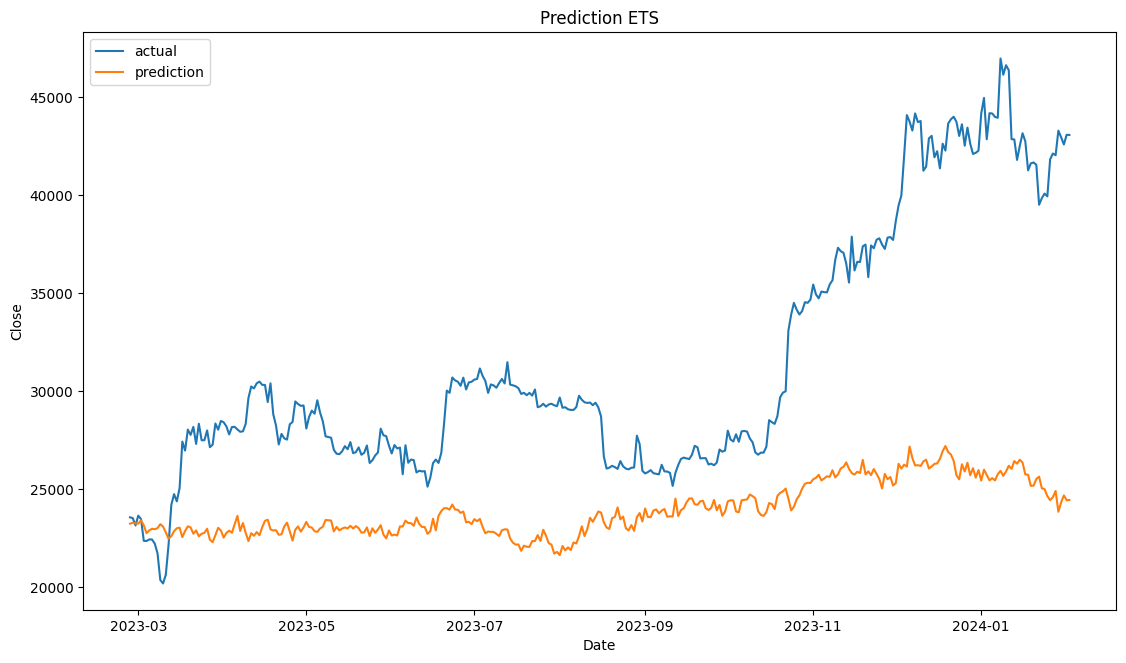

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.set_title("Prediction ETS")
ax.set_ylabel("Close")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [11]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 84113373.52
RMSE: 9171.33
MAE: 7515.17
MAPE: 21.82
SMAPE: 25.35


In [12]:
param_grid = {"global_trend_option": ["linear", "loglinear", "flat", "logistic"]}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [15]:
train

,Close,Closed_1_ago,Closed_2_ago,Closed_3_ago,Closed_4_ago,Closed_5_ago,Closed_6_ago,Closed_7_ago,Date
0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,2014-09-24
1,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,2014-09-25
2,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,2014-09-26
3,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,2014-09-27
4,377.181000,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,2014-09-28
...,...,...,...,...,...,...,...,...,...
3072,24436.353516,24829.148438,24327.642578,24641.277344,24565.601563,23623.474609,24307.841797,22220.804688,2023-02-21
3073,24188.843750,24436.353516,24829.148438,24327.642578,24641.277344,24565.601563,23623.474609,24307.841797,2023-02-22
3074,23947.492188,24188.843750,24436.353516,24829.148438,24327.642578,24641.277344,24565.601563,23623.474609,2023-02-23
3075,23198.126953,23947.492188,24188.843750,24436.353516,24829.148438,24327.642578,24641.277344,24565.601563,2023-02-24


In [20]:
global_trend_options = ["linear", "loglinear", "flat", "logistic"]

dlt_scores = dict()


def dlt_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an DLT model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the DLT model configured with the given parameters.
    """
    return DLT(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        regressor_col=["Closed_1_ago", "Closed_2_ago", "Closed_3_ago", "Closed_4_ago", "Closed_5_ago", "Closed_6_ago", "Closed_7_ago"],
        regressor_sign=["+"] * 7,
        regression_penalty="auto_ridge",
        damped_factor=0.8,
        seed=2,
        verbose=False,
        **ets_best_params,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, dlt_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        dlt_scores[json.dumps(option)] = score

chain 1 |          | 00:00 Status

















































































































chain 1 |██▌       | 00:00 Status
























































































































































chain 1 |██████████| 02:04 Sampling completed                     
chain 2 |██████████| 02:04 Sampling completed                     
chain 3 |██████████| 02:04 Sampling completed                     
chain 4 |██████████| 02:04 Sampling completed                     
























































































































































































































































chain 1 |█████     | 03:36 Iteration:   1 / 250 [  0%]  (Warmup)












































































































chain 1 |██████████| 03:51 Sampling completed                     
chain 2 |██████████| 03:51 Sampling completed                     
chain 3 |██████████| 03:51 Sampling completed                     
chain 4 |██████████| 03:51 Sampling completed                     

chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     




















































































































































































chain 1 |███████▌  | 04:04 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 04:15 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 04:20 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 04:21 Sampling completed                     
chain 2 |██████████| 04:21 Sampling completed                     
chain 3 |██████████| 04:21 Sampling completed                     
chain 4 |██████████| 04:21 Sampling completed                     






chain 1 |          | 00:00 Status


























chain 1 |██▌       | 00:00 Status


























chain 1 |██████████| 04:51 Sampling completed                     
chain 2 |██████████| 04:51 Sampling completed                     
chain 3 |██████████| 04:51 Sampling completed                     
chain 4 |██████████| 04:51 Sampling completed                     


























































































































































































































chain 1 |██████████| 02:04 Sampling completed                     
chain 2 |██████████| 02:04 Sampling completed                     
chain 3 |██████████| 02:04 Sampling completed                     
chain 4 |██████████| 02:04 Sampling completed                     









































































































































































































chain 1 |██████████| 03:42 Sampling completed                     
chain 2 |██████████| 03:42 Sampling completed                     
chain 3 |██████████| 03:42 Sampling completed                     
chain 4 |██████████| 03:42 Sampling completed                     












































































































chain 1 |█████     | 03:44 Iteration:   1 / 250 [  0%]  (Warmup)














































































chain 1 |██████████| 02:20 Sampling completed                     
chain 2 |██████████| 02:20 Sampling completed                     
chain 3 |██████████| 02:20 Sampling completed                     
chain 4 |██████████| 02:20 Sampling completed                     






































































































chain 1 |███████▌  | 04:14 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 04:24 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |          | 04:34 Iteration: 226 / 250 [ 90%]  (Sampling)































































chain 1 |██████████| 05:18 Sampling completed                     
chain 2 |██████████| 05:18 Sampling completed                     
chain 3 |██████████| 05:18 Sampling completed                     
chain 4 |██████████| 05:18 Sampling completed                     



















chain 1 |          | 00:00 Status


















chain 1 |██▌       | 00:00 Status










































































































































































































































chain 1 |██████████| 02:09 Sampling completed                     
chain 2 |██████████| 02:09 Sampling completed                     
chain 3 |██████████| 02:09 Sampling completed                     
chain 4 |██████████| 02:08 Sampling completed                     













chain 1 |██████████| 05:49 Sampling completed                     
chain 2 |██████████| 05:49 Sampling completed                     
chain 3 |██████████| 05:49 Sampling completed                     
chain 4 |██████████| 05:49 Sampling completed                     















































































chain 1 |██████████| 03:35 Sampling completed                     
chain 2 |██████████| 03:35 Sampling completed                     
chain 3 |██████████| 03:35 Sampling completed                     
chain 4 |██████████| 03:35 Sampling completed                     





































chain 1 |█████     | 02:11 Iteration:   1 / 250 [  0%]  (Warmup)



































































chain 1 |██████████| 03:12 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |██████████| 03:18 Sampling completed                     
chain 2 |██████████| 03:18 Sampling completed                     
chain 3 |██████████| 03:18 Sampling completed                     
chain 4 |██████████| 03:18 Sampling completed                     










chain 1 |          | 00:00 Status

















chain 1 |██▌       | 00:00 Status

























































































chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     
















































































chain 1 |██████████| 03:50 Sampling completed                     
chain 2 |██████████| 03:50 Sampling completed                     
chain 3 |██████████| 03:50 Sampling completed                     
chain 4 |██████████| 03:50 Sampling completed                     

































































chain 1 |█████     | 02:36 Iteration:   1 / 250 [  0%]  (Warmup)































































chain 1 |          | 03:28 Iteration: 226 / 250 [ 90%]  (Sampling)

























chain 1 |██████████| 03:42 Sampling completed                     
chain 2 |██████████| 03:42 Sampling completed                     
chain 3 |██████████| 03:42 Sampling completed                     
chain 4 |██████████| 03:42 Sampling completed                     

chain 1 |          | 00:00 Status



































chain 1 |██▌       | 00:00 Status










































chain 1 |██████████| 03:09 Sampling completed                     
chain 2 |██████████| 03:09 Sampling completed                     
chain 3 |██████████| 03:09 Sampling completed                     
chain 4 |██████████| 03:09 Sampling completed                     



































































chain 1 |█████     | 01:21 Iteration:   1 / 250 [  0%]  (Warmup)










chain 1 |██████████| 03:44 Sampling completed                     
chain 2 |██████████| 03:44 Sampling completed                     
chain 3 |██████████| 03:44 Sampling completed                     
chain 4 |██████████| 03:44 Sampling completed                     

































chain 1 |███████▌  | 01:52 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 01:56 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |          | 01:59 Iteration: 226 / 250 [ 90%]  (Sampling)



















chain 1 |██████████| 02:04 Sampling completed                     
chain 2 |██████████| 02:04 Sampling completed                     
chain 3 |██████████| 02:04 Sampling completed                     
chain 4 |██████████| 02:04 Sampling completed                     

































chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     

In [21]:
dlt_best_params = json.loads(min(dlt_scores, key=dlt_scores.get))
dlt_scores

{'{"global_trend_option": "logistic"}': 1502.7524970978775,
 '{"global_trend_option": "flat"}': 1560.9767781516725,
 '{"global_trend_option": "linear"}': 1633.3386005824843,
 '{"global_trend_option": "loglinear"}': 1563.801494007821}

In [22]:
dlt = DLT(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["Closed_1_ago", "Closed_2_ago", "Closed_3_ago", "Closed_4_ago", "Closed_5_ago", "Closed_6_ago", "Closed_7_ago"],
    regressor_sign=["+"] * 7,
    regression_penalty="auto_ridge",
    damped_factor=0.8,
    seed=2,
    verbose=False,
    **ets_best_params,
    **dlt_best_params
)

dlt.fit(train)
p = dlt.predict(df=test[[date_column, "Closed_1_ago", "Closed_2_ago", "Closed_3_ago", "Closed_4_ago", "Closed_5_ago", "Closed_6_ago", "Closed_7_ago"]])
p = p.merge(test, on=date_column, how="left")

chain 1 |          | 00:00 Status




chain 1 |█████     | 00:19 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |          | 00:40 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:45 Sampling completed                     
chain 2 |██████████| 00:45 Sampling completed                     
chain 3 |██████████| 00:45 Sampling completed                     
chain 4 |██████████| 00:45 Sampling completed                     

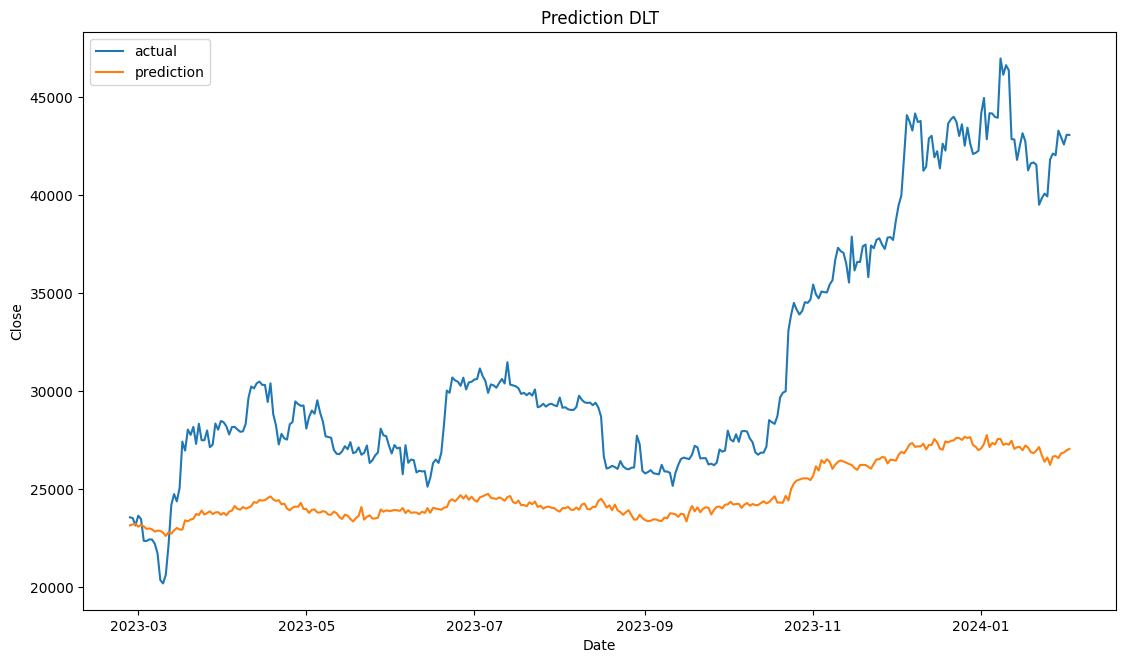

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.set_title("Prediction DLT")
ax.set_ylabel("Close")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [24]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 69055843.92
RMSE: 8309.98
MAE: 6701.12
MAPE: 19.32
SMAPE: 22.10


In [25]:
ktr = KTR(
    date_col=date_column,
    response_col=target_column,
    seasonality=[90, 180, 360],
    prediction_percentiles=[5, 95],
    regressor_col=["Closed_1_ago", "Closed_2_ago", "Closed_3_ago", "Closed_4_ago", "Closed_5_ago", "Closed_6_ago", "Closed_7_ago"],
    seed=2,
    verbose=False,
)

ktr.fit(df=train)

p = ktr.predict(df=test[[date_column, "Closed_1_ago", "Closed_2_ago", "Closed_3_ago", "Closed_4_ago", "Closed_5_ago", "Closed_6_ago", "Closed_7_ago"]])
p = p.merge(test, on=date_column, how="left")

2024-03-08 14:42:31 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
/home/samuell/.local/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


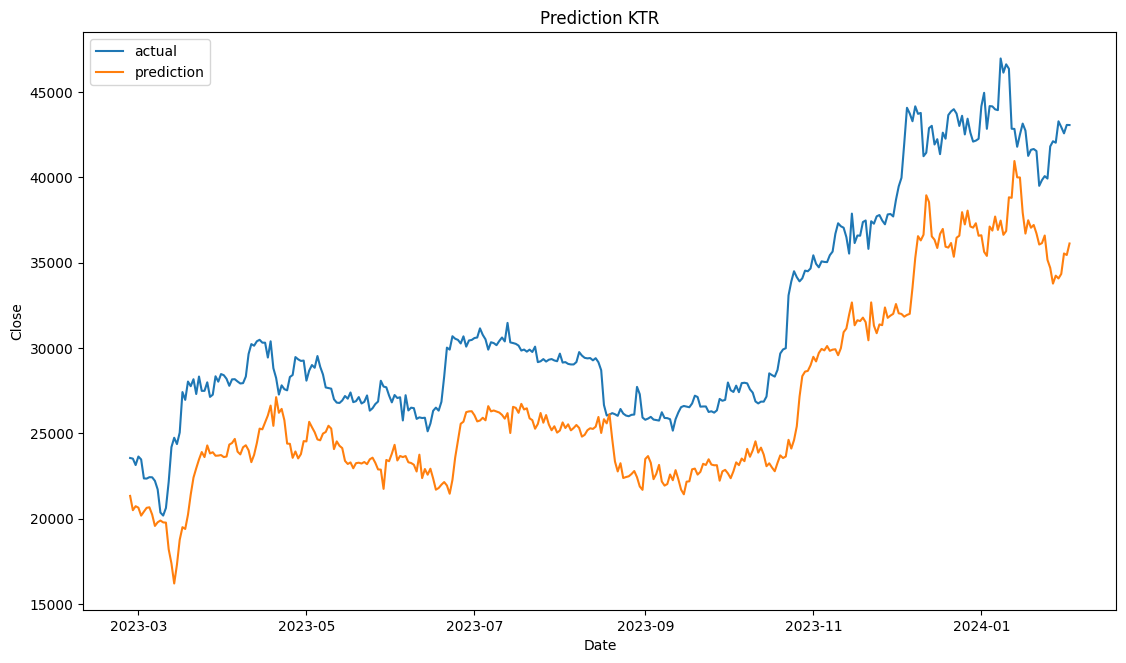

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.set_title("Prediction KTR")
ax.set_ylabel("Close")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [27]:
print_evaluation_metrics(p["prediction"], p[target_column])

Evaluation Metrics:
MSE: 25543240.75
RMSE: 5054.03
MAE: 4673.01
MAPE: 14.69
SMAPE: 16.01
